In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import scipy
from scipy.special import erf
import numpy
from numpy import exp
from numpy.lib.scimath import log, sqrt
from tqdm import tqdm

In [3]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (21, 10)

In [4]:
def selfCorrelation(t,r):
    ts=range(t)
    selfCorrelations = []
    meanR=np.mean(r)
    variance=np.var(r)
    r=np.array(r-meanR)
    for t in tqdm(ts):
        selfCorrelations.append(np.sum([((r[i]*r[i+t])/(len(r)-t)) for i in range(1,len(r)-t)]))
    selfCorrelations=np.array(selfCorrelations)/variance
    return selfCorrelations

In [5]:
def plotEquilibrationData(s,title):
    df1=pd.read_fwf(r'./equilibrationData/output_epot_'+s+'.dat',header=None, infer_nrows=5000)
    df2=pd.read_fwf(r'./equilibrationData/output_etot_'+s+'.dat',header=None, infer_nrows=5000)
    df3=pd.read_fwf(r'./equilibrationData/output_pres_'+s+'.dat',header=None, infer_nrows=5000)
    df1.columns=['nBlocks','estimate','avg','err']
    df2.columns=['nBlocks','estimate','avg','err']
    df3.columns=['nBlocks','estimate','avg','err']
    plt.plot(df1.nBlocks, df1.estimate, label=r'E_pot');
    plt.plot(df2.nBlocks, df2.estimate, label=r'E_tot');
    plt.plot(df3.nBlocks, df3.estimate, label=r'pressure');
    plt.title(title)
    plt.xlabel("Number of step")
    plt.ylabel("Value(natural units)")
    plt.legend()
    plt.show()

In [6]:
def plotAutoCorrelation(s,t):
    df=pd.read_fwf(r'./'+s+'PhaseData/output_etot.dat',header=None, infer_nrows=1000000)
    df.columns=['nBlocks','estimate','avg','err']
    selfcorr= selfCorrelation(t,df.estimate)
    plt.xlabel(r'$\Delta t$')
    plt.ylabel('autocorrelation')
    plt.plot(t,selfcorr);
    plt.title('Autocorrelation for the '+s+' phase');
    plt.grid()
    plt.show();

In [7]:
def varianceBlockSize(data,maxT):
    length= len(data)
    factors=[x for x in range(2,maxT) if len(data)%x==0]
    errors=[]
    for d in tqdm(factors):
        size=int(length/d)
        tempData = data.reshape([size,d])
        means=np.mean(tempData, axis=1)
        meansSquare=np.square(means)
        errors.append(np.sqrt((np.mean(meansSquare)-np.square(np.mean(means)))/(size-1)))
    return factors,errors

In [8]:
def printVarianceBlock(s,t):
    df=pd.read_fwf(r'./'+s+'PhaseData/output_etot.dat',header=None, infer_nrows=1000000)
    df.columns=['nBlocks','estimate','avg','err']
    factors,errors=varianceBlockSize(np.array(df.estimate), range(0,t))
    plt.plot(factors,errors)
    plt.title('Statistical uncertainty for '+s+' phase')
    plt.xlabel("number of blocks")
    plt.ylabel("statistical uncertainty")
    plt.grid()
    plt.xlim([0,t])
    plt.show()    

In [9]:
def printVarianceAutoCorrelation(s,t):
    df=pd.read_fwf(r'./'+s+'PhaseData/output_etot.dat',header=None, infer_nrows=1000000)
    df.columns=['nBlocks','estimate','avg','err']
    
    factors,errors=varianceBlockSize(np.array(df.estimate), t)
    selfcorr= selfCorrelation(t,df.estimate)
    
    plt.plot(range(t),selfcorr, label='autocorrelation');
    plt.plot(factors,errors/max(errors),label='normalizedstatistical uncertainty')
    plt.title('Statistical uncertainty for '+s+' phase')
    plt.xlabel("number of blocks")
    plt.ylabel("statistical uncertainty")
    plt.grid()
    plt.xlim([0,t])
    plt.legend()
    plt.show()  

## Exercise 7.02 ##
In this exercise we are required to study the autocorrelation function of the internal energy obtained by the Montecarlo simulation for three different thermodynamic conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)
The quantities are expressed in the units defined by the Lennard-Jones potential

We will then use the data to decide the size of the blocks by estimating the the size neccesary to have a low correlation.

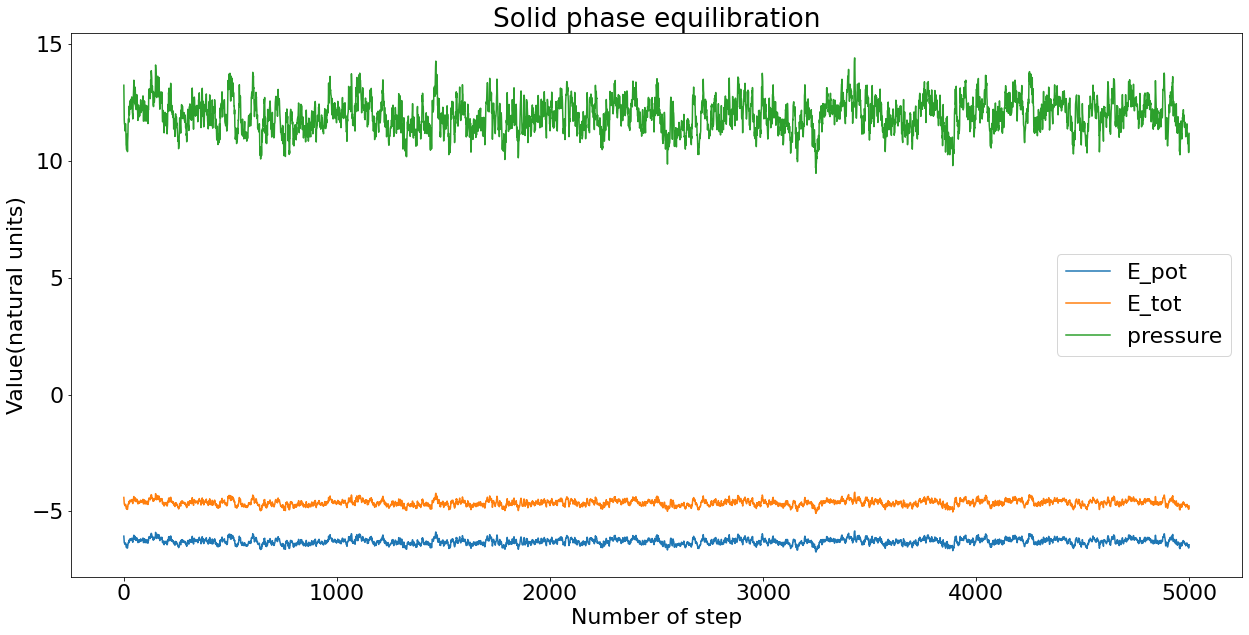

In [8]:
plotEquilibrationData('solid', 'Solid phase equilibration')

For the solid state the FCC is a stable configuration, and we don't need any further equilibration. We can now see the liquid and gaseous phases:

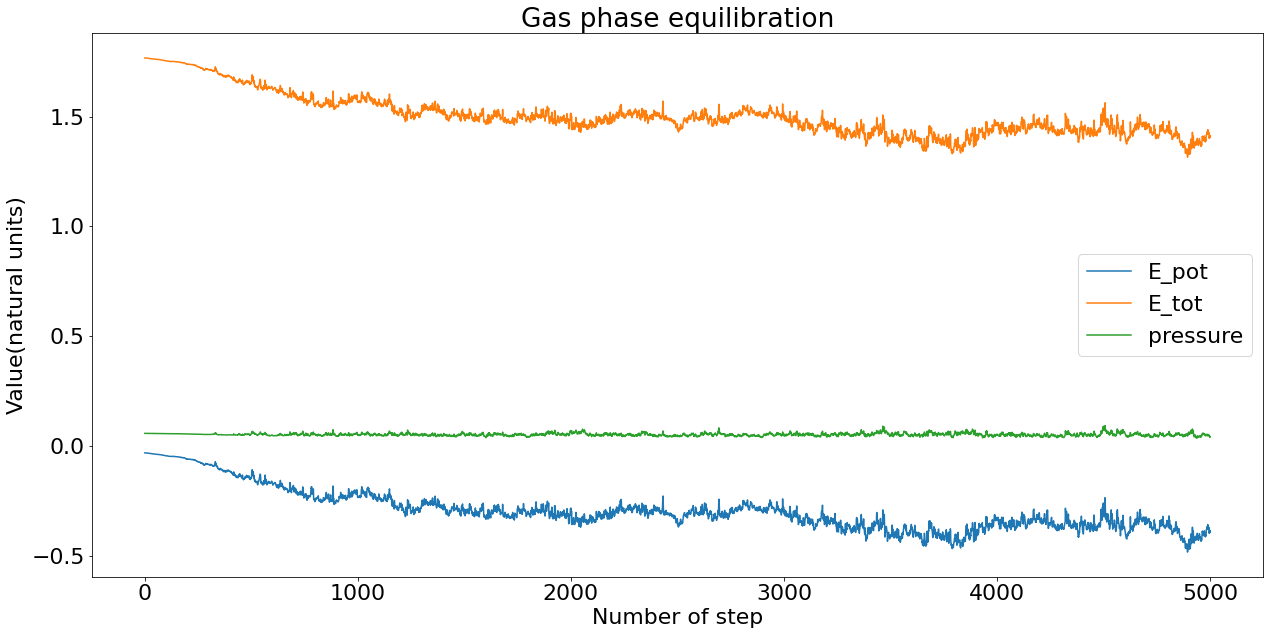

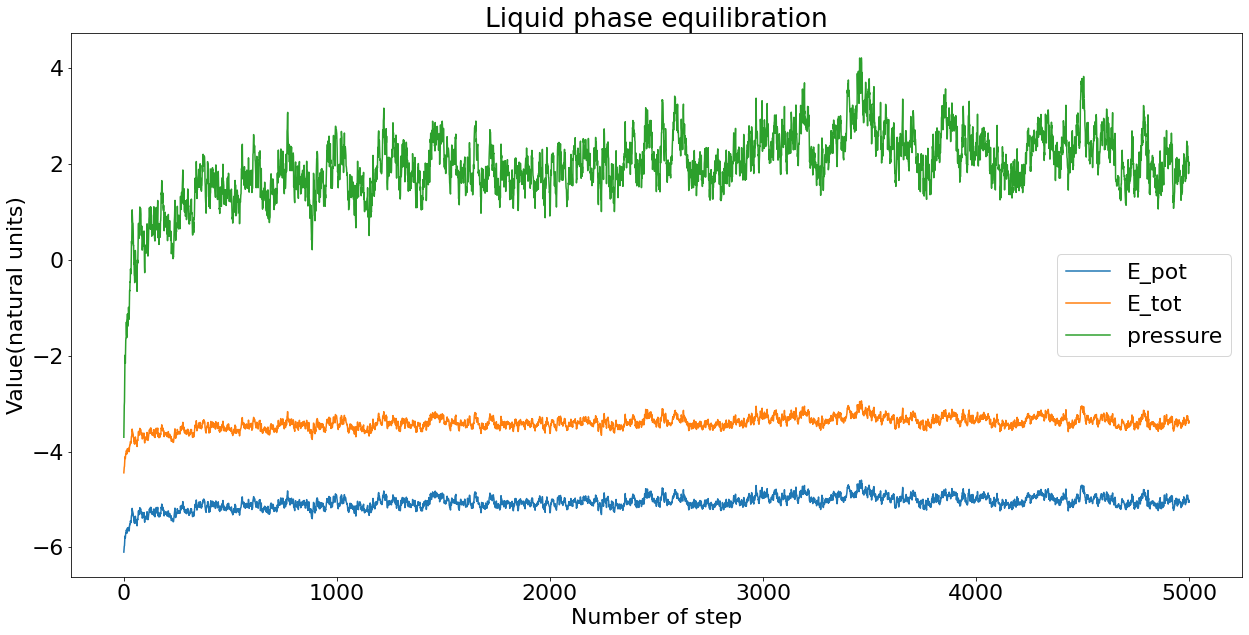

In [9]:
plotEquilibrationData('gas', 'Gas phase equilibration')
plotEquilibrationData('liquid', 'Liquid phase equilibration')

As we can see after $1000$ monte carlo steps the simulations are equilibrated. We will use, from now on, the configurations we obtained after these first simulations as a starting point from all the other configurations.

To have an acceeptance rate of $\approx 0.5$ we use a step of $0.1$ in the solid phase, a step of $0.2$ in the liquid phase and a step of $5.0$ in the gas phase.


To estimate the statistical uncertainty we use datablocking: we divide our data in batches of a fixed size, we calulate the mean $m$ of the quantity we are studying for each batch and we the calculate the uncertainty with the formula:
$$/sigma=\sqrt{\frac{\langle m^2\rangle-\langle m \rangle^2}{N-1}}$$
A question that naturally arises is the size of the blocks we want to use. If the blocks size is too small we are the different samples aren't independent, and the uncertainty will be underestimated.

Starting from the equilibrated configurations we obatined in the previous block we can study the autocorrelation of the internal energy to undestand how big the blocks should be. We will study the autocorrelation function:
$$g_{U}(\tau)=\frac{\sum_{t}(U(t+\tau)-\bar{U})((U(t)-\bar{U}))}{\sum_{t}(U(t)-\bar{U})^2}$$
with the lagtime $\tau$ in the range $[0,1000]$. The block size should be bigger tha the characteristical correlation time.
We will also try to estimate the uncertainty with different block size, to verify that it increases along with the size of the blocks up to a stable value, that is reached when the size is bigger than the correlation length


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:46<00:00,  2.46it/s]


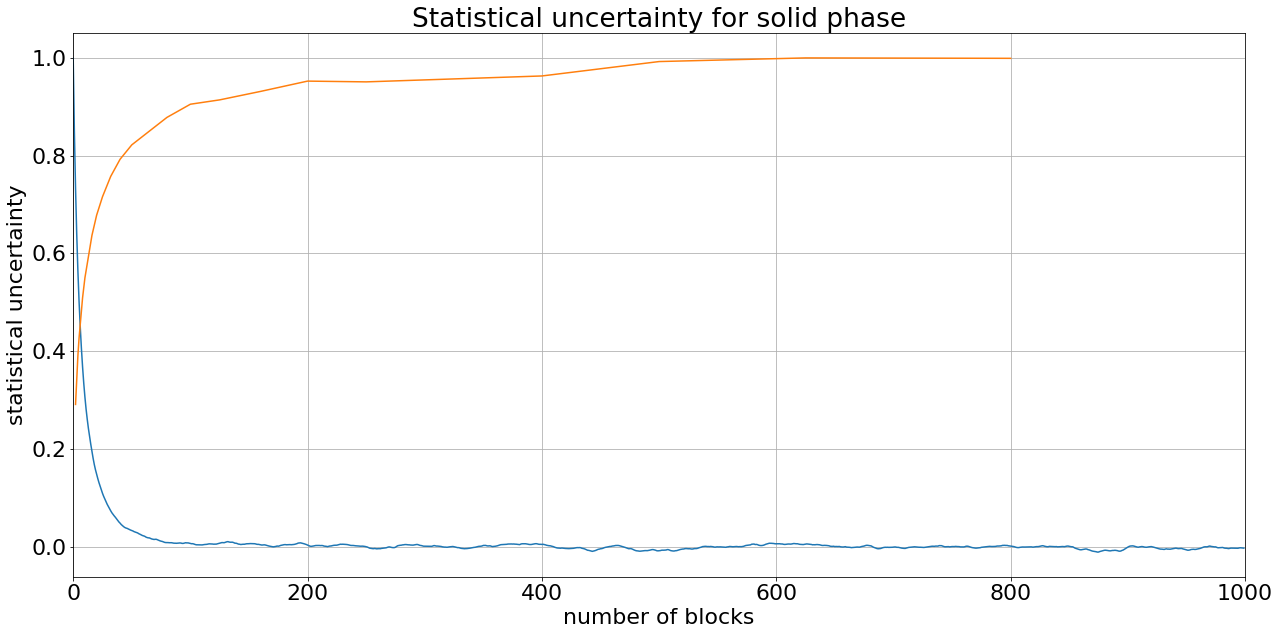

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:50<00:00,  2.43it/s]


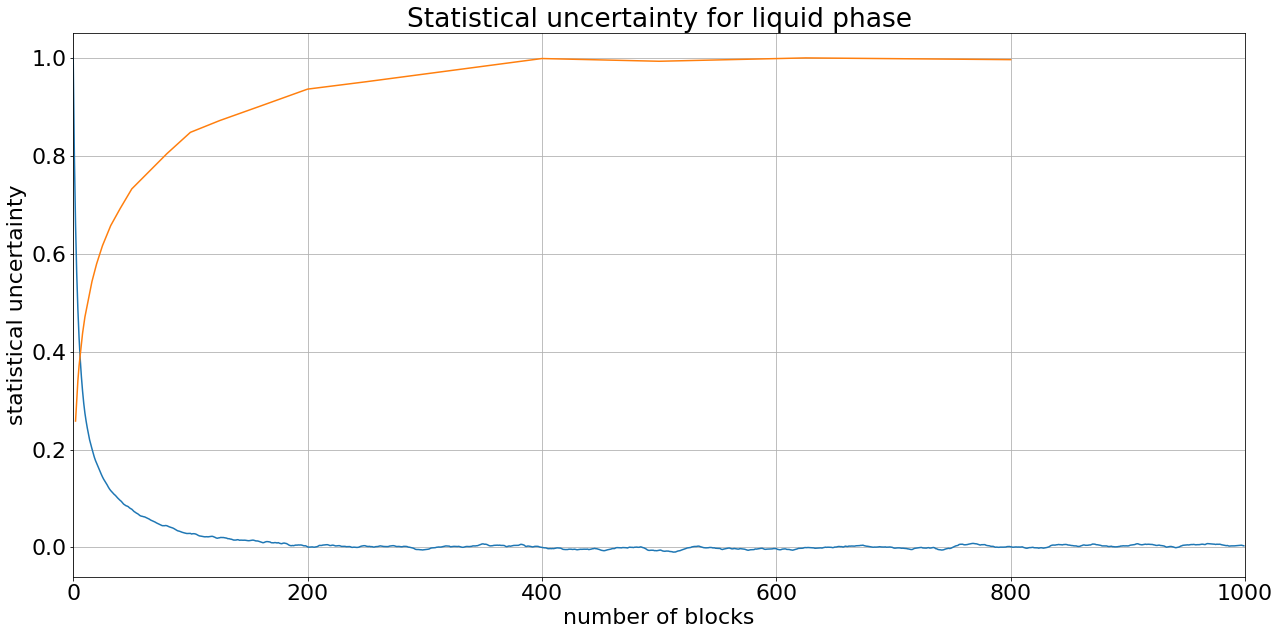

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:31<00:00,  2.55it/s]


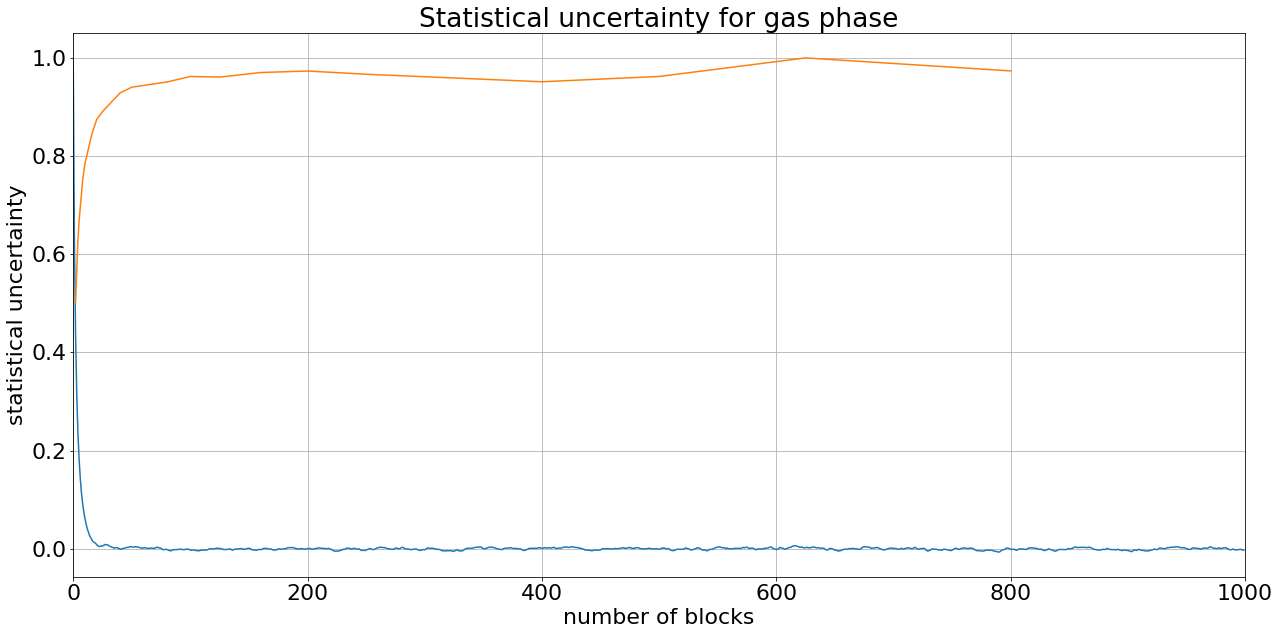

In [42]:
printVarianceAutoCorrelation('solid',1000)
printVarianceAutoCorrelation('liquid',1000)
printVarianceAutoCorrelation('gas',1000)

We see the characteristic autocorrelation time for each phases, and we can see that it is of the same order of magnitude of the length of the block in datablocking that underestimate the uncertainty.

We can now watch an important microscopic properties: the spatial autocorrelation function, defined as:  
$$g(r,r')=\langle \rho(r) \rho(r')\rangle$$
It is a relevant quantity for plenty of reasons:it has a characteristic shape for each phases, and it tells us something about the microscopic structure of the phase. For example in a solid we could reconstruct the crystal structure by looking at the correlation function.
But it also has a macroscopic meaning: it can be shown to be related to the isothermal compressibility via the fluctuation-dissipation theorem.
In the next block we plot the correlation function for different phases, obtained by Monte Carlo simulation and by MD simulations. Each simulation has been run for $20$ blocks of $2000$ steps each.

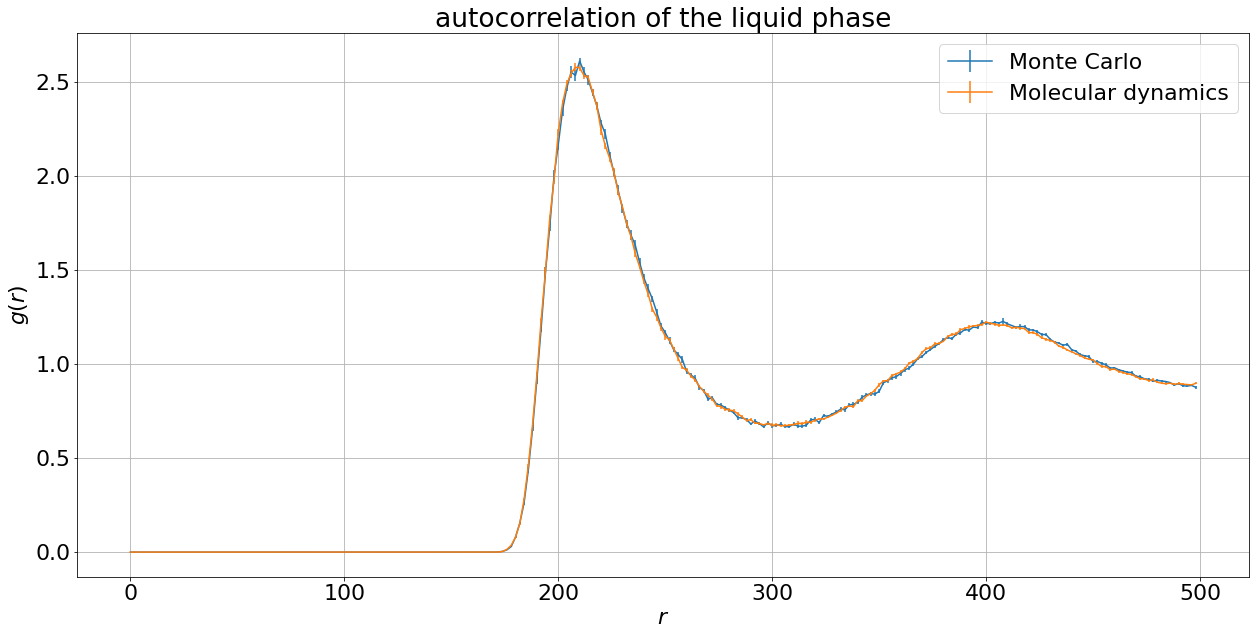

In [54]:
df1=pd.read_fwf(r'./correlationData/output_corr_liquid_MC.dat',header=None, infer_nrows=1000000)
df2=pd.read_fwf(r'./correlationData/output_corr_liquid_MD.dat',header=None, infer_nrows=1000000)
datas=df1[1]
g=[]
g2=[]
errs=[]
errs2=[]
datas=datas[19].split(';')
for i in range(len(datas)-1):
    tup=tuple(map(float, datas[i][1:-1:].split(',')))
    g.append(tup[1])
    errs.append(tup[2])
datas2=df2[1]
datas2=datas2[19].split(';')
for i in range(len(datas2)-1):
    tup=tuple(map(float, datas2[i][1:-1:].split(',')))
    g2.append(tup[1])
    errs2.append(tup[2])
plt.errorbar(x=range(0,len(g),2),y=g[::2],yerr=errs[::2],label='Monte Carlo')
plt.errorbar(x=range(0,len(g),2),y=g2[::2],yerr=errs2[::2],label='Molecular dynamics')
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r$')
plt.legend()
plt.grid()
plt.title('autocorrelation of the liquid phase');

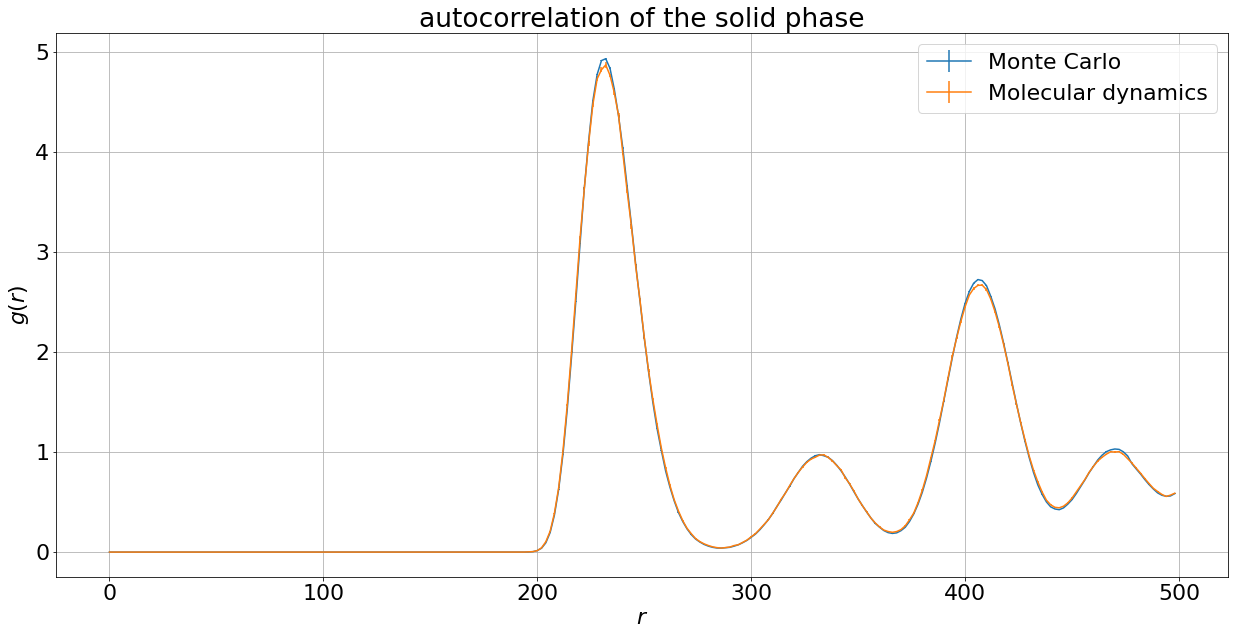

In [51]:
df1=pd.read_fwf(r'./correlationData/output_corr_solid_MC.dat',header=None, infer_nrows=1000000)
df2=pd.read_fwf(r'./correlationData/output_corr_solid_MD.dat',header=None, infer_nrows=1000000)
datas=df1[1]
g=[]
g2=[]
errs=[]
errs2=[]
datas=datas[19].split(';')
for i in range(len(datas)-1):
    tup=tuple(map(float, datas[i][1:-1:].split(',')))
    g.append(tup[1])
    errs.append(tup[2])
datas2=df2[1]
datas2=datas2[19].split(';')
for i in range(len(datas2)-1):
    tup=tuple(map(float, datas2[i][1:-1:].split(',')))
    g2.append(tup[1])
    errs2.append(tup[2])
plt.errorbar(x=range(0,len(g),2),y=g[::2],yerr=errs[::2],label='Monte Carlo')
plt.errorbar(x=range(0,len(g),2),y=g2[::2],yerr=errs2[::2],label='Molecular dynamics')
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r$')
plt.legend()
plt.grid()
plt.title('autocorrelation of the solid phase');

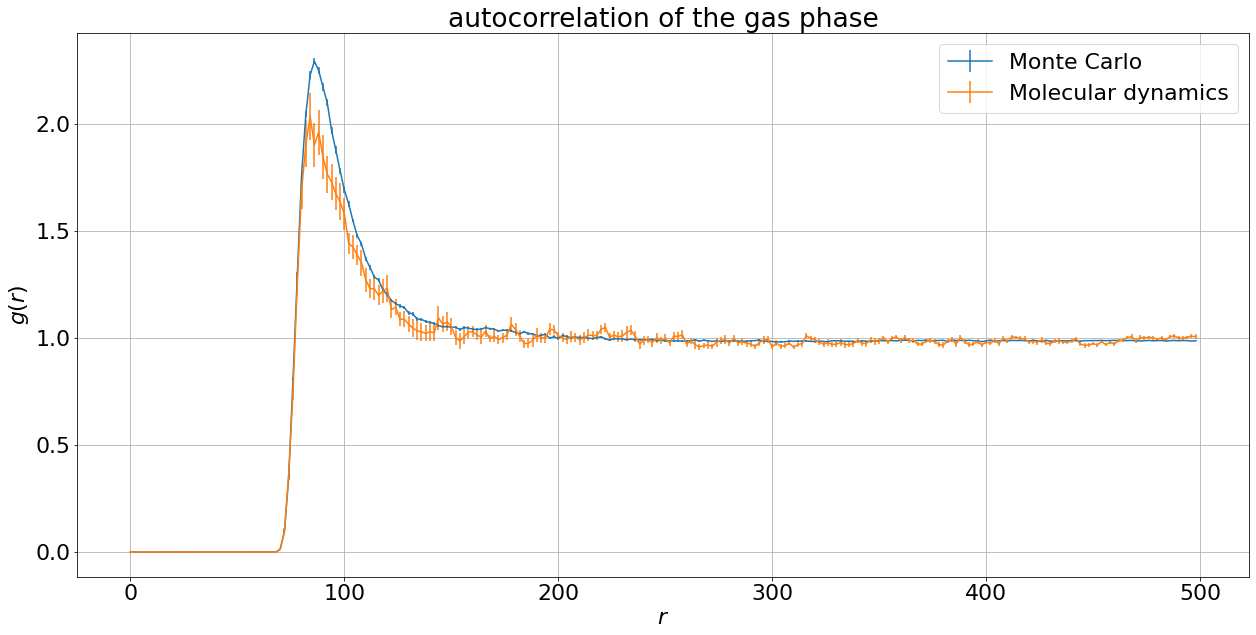

In [53]:
df1=pd.read_fwf(r'./correlationData/output_corr_gas_MC.dat',header=None, infer_nrows=1000000)
df2=pd.read_fwf(r'./correlationData/output_corr_gas_MD.dat',header=None, infer_nrows=1000000)
datas=df1[1]
g=[]
g2=[]
errs=[]
errs2=[]
datas=datas[19].split(';')
for i in range(len(datas)-1):
    tup=tuple(map(float, datas[i][1:-1:].split(',')))
    g.append(tup[1])
    errs.append(tup[2])
datas2=df2[1]
datas2=datas2[19].split(';')
for i in range(len(datas2)-1):
    tup=tuple(map(float, datas2[i][1:-1:].split(',')))
    g2.append(tup[1])
    errs2.append(tup[2])
plt.errorbar(x=range(0,len(g),2),y=g[::2],yerr=errs[::2],label='Monte Carlo')
plt.errorbar(x=range(0,len(g),2),y=g2[::2],yerr=errs2[::2],label='Molecular dynamics')
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r$')
plt.legend()
plt.grid()
plt.title('autocorrelation of the gas phase');